In [1]:
from google.colab import drive,files
files.upload()

Saving QuoraQuestionPairDataset.zip to QuoraQuestionPairDataset.zip


In [2]:
!unzip QuoraQuestionPairDataset.zip

Archive:  QuoraQuestionPairDataset.zip
  inflating: questions.csv           


In [49]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import os
import sys
import re
import datetime as dt
import string

In [135]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
%matplotlib inline

from tqdm.notebook import tqdm

In [47]:
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [6]:
#os.listdir()

['.config', 'QuoraQuestionPairDataset.zip', 'questions.csv', 'sample_data']

In [7]:
df = pd.read_csv("questions.csv")

In [8]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


Text(0.5, 1.0, 'Count of missing values per column')

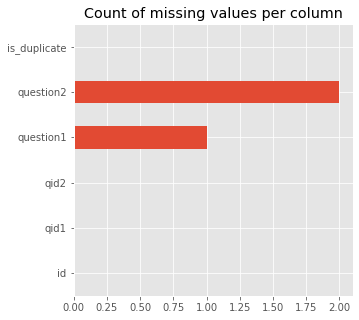

In [9]:
plt.figure(figsize=(5, 5))
df.isna().sum(axis=0).plot.barh()
plt.title('Count of missing values per column')

In [10]:
nan_rows = df[df.isnull().any(1)]
print(nan_rows) # output rows with null entry

df = df.fillna('') # fillna

nan_rows = df[df.isnull().any(1)]
print(nan_rows) # output rows with null entry

            id  ...  is_duplicate
105796  105796  ...             0
201871  201871  ...             0
363416  363416  ...             0

[3 rows x 6 columns]
Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404351 entries, 0 to 404350
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404351 non-null  int64 
 1   qid1          404351 non-null  int64 
 2   qid2          404351 non-null  int64 
 3   question1     404351 non-null  object
 4   question2     404351 non-null  object
 5   is_duplicate  404351 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [12]:
duplicates =  df.duplicated() #['qid1','qid2','is_duplicate']
duplicates.sum(axis=0)
df[duplicates]

,id,qid1,qid2,question1,question2,is_duplicate


In [13]:
df = df.drop_duplicates()

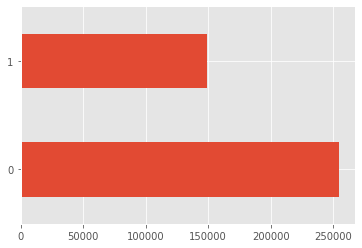

In [14]:
df['is_duplicate'].value_counts().plot.barh()

In [16]:
print("{:.2f}% of the question pairs are not duplicates".format(100*df['is_duplicate'].value_counts().to_frame().iloc[0]['is_duplicate']/df.shape[0]))
print("{:.2f}% of the question pairs are duplicates".format(100*df['is_duplicate'].value_counts().to_frame().iloc[1]['is_duplicate']/df.shape[0]))

63.08% of the question pairs are not duplicates
36.92% of the question pairs are duplicates


In [17]:
all_questions = [*df['question1'].to_list(), *df['question2'].to_list()]
unique_questions = list(set(all_questions))
print("Number of unique questions:", len(unique_questions))

Number of unique questions: 537388


In [18]:
print("{} qids intersect in pair formation".format(len(list(set(df.qid2) & set(df.qid1)))))

7474 qids intersect in pair formation


In [ ]:

#intersection = list(set(df.qid2) & set(df.qid1))
#qid_list = [*df['qid1'].to_list(),*df['qid2'].to_list()]

#print("{}", )
#qid2_list = [*df['qid2'].to_list()]
#diff_2_from_1 = [qid for qid in qid2_list if qid not in intersection]
#unique_qids = [*df['qid1'].to_list(), *diff_2_from_1]

In [20]:
freq = nltk.FreqDist(all_questions)

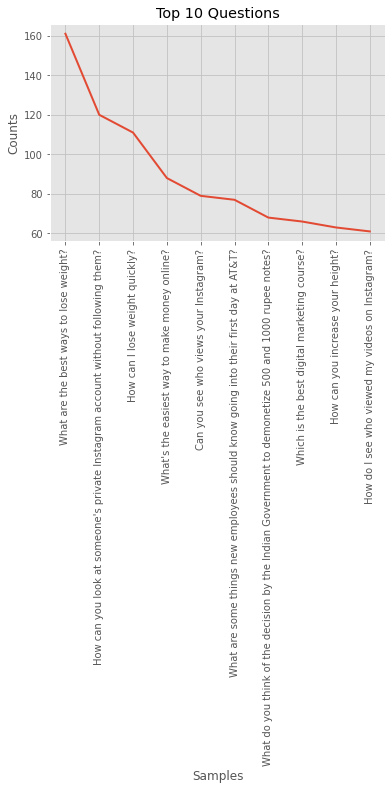

Most asked question being: What are the best ways to lose weight?


In [21]:
freq.plot(10, cumulative=False, title="Top 10 Questions")
print("Most asked question being:",freq.max())

In [22]:
more_than_once = [q for q,count in freq.items() if count >= 2]

In [23]:
print("{0:.2f}% of questions occur more than once".format(100*len(more_than_once)/len(unique_questions)))

20.82% of questions occur more than once


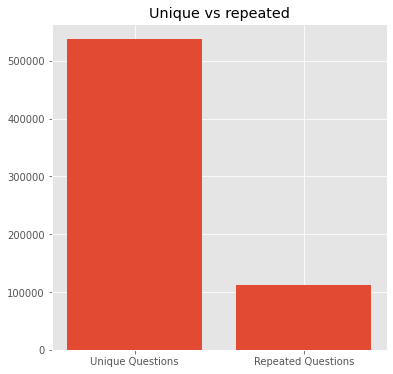

In [25]:
x = ["Unique Questions","Repeated Questions"]
xpos = [i for i, _ in enumerate(x)]
plt.figure(figsize=(6,6))
plt.title("Unique vs repeated")
plt.bar(xpos, [len(unique_questions),len(more_than_once)])
plt.xticks(xpos, x)
plt.show()

#Preprocessing Text

In [81]:

class ProcessText:
  def __init__(self):
    if not all(pkg in globals() for pkg in ("string","re","nltk","BeautifulSoup","SnowballStemmer","tqdm")):
      raise Exception("[Error] Dependencies not satisfied.")
    
    self.stop_words = ['the','a','an','and','but','if','or','because','as','what','which','this','that','these','those','then',
              'just','so','than','such','both','through','about','for','is','of','while','during','to','What','Which',
              'Is','If','While','This']
    self.doc_list = []

  def process_corpus(self, corpus=[], remove_stop_words=True, stem_words=False):
    self.doc_list = []
    if len(corpus) != 0:
      for doc in tqdm(corpus):
          self.doc_list.append(self.process_text(remove_stop_words, stem_words,doc))
      return self.doc_list

  def process_text(self, remove_stop_words, stem_words, text=''):
    if len(text) != 0:
      text = self.__remove_html(text)
      text = self.__clean_text(text)
      text = self.__clean_punctuation(text)
      if remove_stop_words:
        text = self.__remove_stopwords(text)
      if stem_words:
        text = self.__stem(text)
      return text

  def __remove_html(self,txt):
    bt_soup = BeautifulSoup(txt)
    txt = bt_soup.get_text()
    del bt_soup
    return txt
  
  def __clean_text(self,text):
    # Clean the text
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r"what's", "", text)
    text = re.sub(r"What's", "", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r" m ", " am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"60k", " 60000 ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e-mail", "email", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"quikly", "quickly", text)
    text = re.sub(r" usa ", " America ", text)
    text = re.sub(r" USA ", " America ", text)
    text = re.sub(r" u s ", " America ", text)
    text = re.sub(r" uk ", " England ", text)
    text = re.sub(r" UK ", " England ", text)
    text = re.sub(r"india", "India", text)
    text = re.sub(r"switzerland", "Switzerland", text)
    text = re.sub(r"china", "China", text)
    text = re.sub(r"chinese", "Chinese", text) 
    text = re.sub(r"imrovement", "improvement", text)
    text = re.sub(r"intially", "initially", text)
    text = re.sub(r"quora", "Quora", text)
    text = re.sub(r" dms ", "direct messages ", text)  
    text = re.sub(r"demonitization", "demonetization", text) 
    text = re.sub(r"actived", "active", text)
    text = re.sub(r"kms", " kilometers ", text)
    text = re.sub(r"KMs", " kilometers ", text)
    text = re.sub(r" cs ", " computer science ", text) 
    text = re.sub(r" upvotes ", " up votes ", text)
    text = re.sub(r" iPhone ", " phone ", text)
    text = re.sub(r"\0rs ", " rs ", text) 
    text = re.sub(r"calender", "calendar", text)
    text = re.sub(r"ios", "operating system", text)
    text = re.sub(r"gps", "GPS", text)
    text = re.sub(r"gst", "GST", text)
    text = re.sub(r"programing", "programming", text)
    text = re.sub(r"bestfriend", "best friend", text)
    text = re.sub(r"dna", "DNA", text)
    text = re.sub(r"III", "3", text) 
    text = re.sub(r"the US", "America", text)
    text = re.sub(r"Astrology", "astrology", text)
    text = re.sub(r"Method", "method", text)
    text = re.sub(r"Find", "find", text) 
    text = re.sub(r"banglore", "Banglore", text)
    text = re.sub(r" J K ", " JK ", text)
    return text

  def __clean_punctuation(self,text):
    #text = ''.join([c for c in text if c not in punctuation])
    # alternatively
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

  def __remove_stopwords(self,text):
    text = text.split()
    text = [w for w in text if not w in self.stop_words]
    text = " ".join(text)
    return text


  def __stem(self,text):
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    return text

In [82]:
pt = ProcessText()

In [85]:
df['question1'] = pt.process_corpus(df['question1'])
df['question2'] = pt.process_corpus(df['question2'])

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [ ]:
df.isna().sum().plot.barh()

nan_rows = df[df.isna().any(1)]
print(nan_rows)

df = df.fillna('')

nan_rows = df[df.isna().any(1)]
print(nan_rows)

#Deriving Features



* freq_qid1 = Frequency of qid1's
* freq_qid2 = Frequency of qid2's
* q1len = Length of q1
* q2len = Length of q2
* q1_n_words = Number of words in Question 1
* q2_n_words = Number of words in Question 2
* word_Common = (Number of common unique words in Question 1 and   Question 2)
* word_Total =(Total num of words in Question 1 + Total num of words in Question 2)
* word_share = (word_common)/(word_Total)
* freq_q1+freq_q2 = sum total of frequency of qid1 and qid2
* freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2


Credit/Reference 

Dwarika Teli @dwarika [Kaggle]


In [114]:
# Freq of occurance
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')

# Length of question
df['q1len'] = df['question1'].str.len() 
df['q2len'] = df['question2'].str.len()

#Number of words
df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

In [115]:
df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words
0,0,1,2,step by step guide invest in share market in I...,step by step guide invest in share market,0,1,1,50,41,10,8
1,1,3,4,story Kohinoor Koh i Noor Diamond,would happen Indian government stole Kohinoor ...,0,1,1,33,69,6,11
2,2,5,6,How can I increase speed my internet connectio...,How can Internet speed be increased by hacking...,0,1,1,57,50,10,9


In [123]:
def normalized_word_common(row):
    text1 = row['question1']
    text2 = row['question2']
    w1 = set(map(lambda word: word.lower().strip(), text1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), text2.split(" ")))    
    return int(len(w1 & w2))

#normalized_word_Common('step by step guide invest in share market','step by step guide invest in share market')

In [124]:
df['word_common'] = df.apply(normalized_word_common, axis=1)

In [125]:
df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common
0,0,1,2,step by step guide invest in share market in I...,step by step guide invest in share market,0,1,1,50,41,10,8,7
1,1,3,4,story Kohinoor Koh i Noor Diamond,would happen Indian government stole Kohinoor ...,0,1,1,33,69,6,11,5
2,2,5,6,How can I increase speed my internet connectio...,How can Internet speed be increased by hacking...,0,1,1,57,50,10,9,4


In [126]:
def normalized_word_total(row):
  w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
  w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
  return 1.0 * (len(w1) + len(w2))


In [127]:
df['word_total'] = df.apply(normalized_word_total, axis=1)

In [130]:
def normalized_word_share(row):
  w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
  w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
  return 1.0 * len(w1 & w2)/(len(w1) + len(w2))

In [131]:
df['word_share'] = df.apply(normalized_word_share, axis=1)

In [132]:
df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

In [133]:
df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,step by step guide invest in share market in I...,step by step guide invest in share market,0,1,1,50,41,10,8,7,15.0,0.466667,2,0
1,1,3,4,story Kohinoor Koh i Noor Diamond,would happen Indian government stole Kohinoor ...,0,1,1,33,69,6,11,5,17.0,0.294118,2,0
2,2,5,6,How can I increase speed my internet connectio...,How can Internet speed be increased by hacking...,0,1,1,57,50,10,9,4,19.0,0.210526,2,0


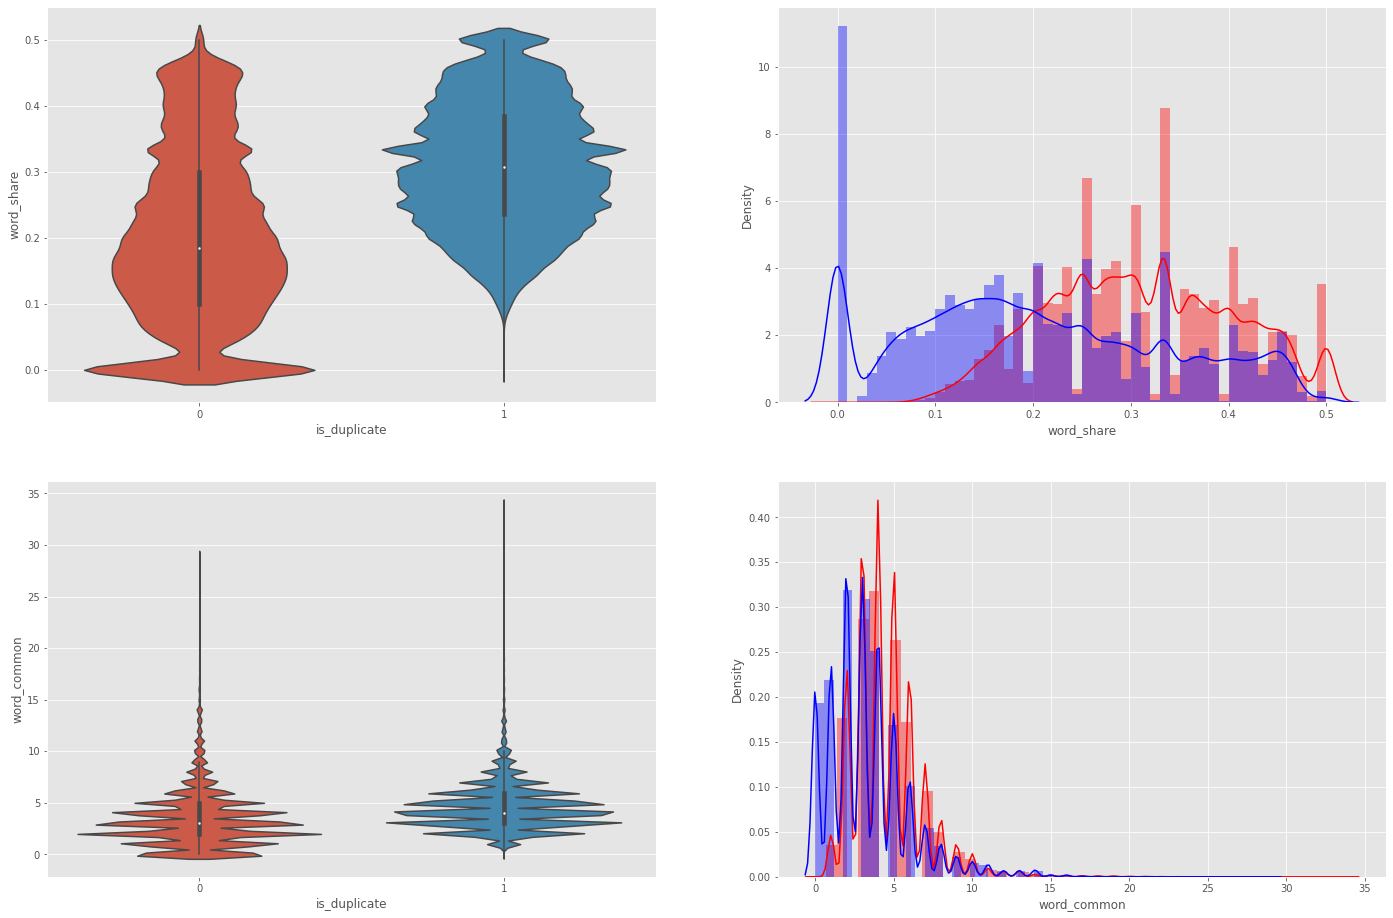

In [149]:
warnings.filterwarnings("ignore", category=FutureWarning)

plt.figure(figsize=(24, 16))
df_dup = df[df['is_duplicate'] == 1.0]
df_non_dup = df[df['is_duplicate'] == 0.0]

plt.subplot(2,2,1)
sns.violinplot( y = 'word_share', x="is_duplicate", data = df[0:])

plt.subplot(2,2,2)
sns.distplot(df_dup['word_share'][0:] , label = "duplicate", color = 'red')
sns.distplot(df_non_dup['word_share'][0:] , label = "not duplicate" , color = 'blue' )

plt.subplot(2,2,3)
sns.violinplot( y = 'word_common', x="is_duplicate", data = df[0:])

plt.subplot(2,2,4)
sns.distplot(df_dup['word_common'][0:] , label = "duplicate", color = 'red')
sns.distplot(df_non_dup['word_common'][0:] , label = "not duplicate" , color = 'blue' )
plt.show()

In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404351 entries, 0 to 404350
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            404351 non-null  int64  
 1   qid1          404351 non-null  int64  
 2   qid2          404351 non-null  int64  
 3   question1     404351 non-null  object 
 4   question2     404351 non-null  object 
 5   is_duplicate  404351 non-null  int64  
 6   freq_qid1     404351 non-null  int64  
 7   freq_qid2     404351 non-null  int64  
 8   q1len         404351 non-null  int64  
 9   q2len         404351 non-null  int64  
 10  q1_n_words    404351 non-null  int64  
 11  q2_n_words    404351 non-null  int64  
 12  word_common   404351 non-null  int64  
 13  word_total    404351 non-null  float64
 14  word_share    404351 non-null  float64
 15  freq_q1+q2    404351 non-null  int64  
 16  freq_q1-q2    404351 non-null  int64  
dtypes: float64(2), int64(13), object(2)
memory usage

In [156]:
y = df["is_duplicate"]

In [152]:
df.drop(labels=['qid1','qid2','question1','question2','is_duplicate','id'],axis=1,inplace=True)

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404351 entries, 0 to 404350
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   freq_qid1    404351 non-null  int64  
 1   freq_qid2    404351 non-null  int64  
 2   q1len        404351 non-null  int64  
 3   q2len        404351 non-null  int64  
 4   q1_n_words   404351 non-null  int64  
 5   q2_n_words   404351 non-null  int64  
 6   word_common  404351 non-null  int64  
 7   word_total   404351 non-null  float64
 8   word_share   404351 non-null  float64
 9   freq_q1+q2   404351 non-null  int64  
 10  freq_q1-q2   404351 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 57.0 MB


In [158]:
from sklearn.model_selection import train_test_split as tts
from prettytable import PrettyTable 

In [162]:
X_train, X_test, y_train, y_test = tts(df, y, test_size = 0.2, random_state = 0)

In [199]:
tts_table = PrettyTable(["Data","No. of points","Class-0","Class-1"]) 
tts_table.add_row(["Train", ''+str(X_train.shape)+'|'+str(y_train.shape),y_train.value_counts()[0],y_train.value_counts()[1]])
tts_table.add_row(["Test",''+str(X_test.shape)+'|'+str(y_test.shape),y_test.value_counts()[0],y_test.value_counts()[1]])
print(tts_table)    

+-------+------------------------+---------+---------+
|  Data |     No. of points      | Class-0 | Class-1 |
+-------+------------------------+---------+---------+
| Train | (323480, 11)|(323480,) |  204079 |  119401 |
|  Test |  (80871, 11)|(80871,)  |  50966  |  29905  |
+-------+------------------------+---------+---------+


Logistic Regression

In [200]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss

In [201]:
class CalibSGDClassifier:

  def __init__(self, alpha=[10 ** x for x in range(-5, 2)]):
    self.alpha = alpha
    self.log_error_array=[]

  def train(self,X_train,y_train,X_test,y_test,loss='log',penalty='l2',calib_method="sigmoid"):
    self.log_error_array=[]
    for i in tqdm(self.alpha):
      clf = SGDClassifier(alpha=i, penalty=penalty, loss=loss, random_state=42)
      clf.fit(X_train, y_train)
      sig_clf = CalibratedClassifierCV(clf, method=calib_method) #Platt Scaling
      sig_clf.fit(X_train, y_train)
      predict_y = sig_clf.predict_proba(X_test)
      self.log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
      print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

    self.__plot_loss(self.alpha,self.log_error_array)

  def __plot_loss(self,alpha=[],log_error_array=[]):
    plt.close()
    fig, ax = plt.subplots()
    ax.plot(alpha, log_error_array,c='g')
    for i, txt in enumerate(np.round(log_error_array,3)):
      ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
      plt.grid()
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha i's")
    plt.ylabel("Error measure")
    plt.show()

  def get_best_clf(self,X_train,y_train):
    best_alpha = np.argmin(self.log_error_array)
    print("Best reg. const value is {}".format(self.alpha[best_alpha]))
    print("Training final model:")
    print("***************")
    clf = SGDClassifier(alpha=self.alpha[best_alpha], penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    return sig_clf

For values of alpha =  1e-05 The log loss is: 0.5809286494245858
For values of alpha =  0.0001 The log loss is: 0.5746763139370579
For values of alpha =  0.001 The log loss is: 0.5732806264021577
For values of alpha =  0.01 The log loss is: 0.5713162997832056
For values of alpha =  0.1 The log loss is: 0.5727122028880391
For values of alpha =  1 The log loss is: 0.5780823044326644
For values of alpha =  10 The log loss is: 0.6182179551436703



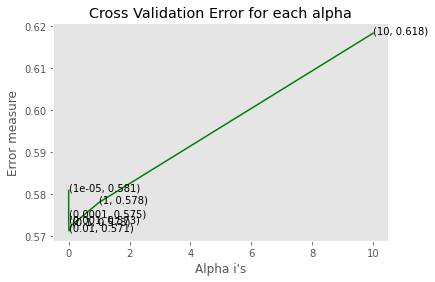

In [202]:
cal_sgd_clf = CalibSGDClassifier()
cal_sgd_clf.train(X_train,y_train,X_test,y_test,loss='log',penalty='l2',calib_method="sigmoid")

Best reg. const value is 0.01
Training final model:
***************
For values of best alpha =  0.01 The train log loss is: 0.5699423355915874
For values of best alpha =  0.01 The test log loss is: 0.5713162997832056
Total number of data points : 80871


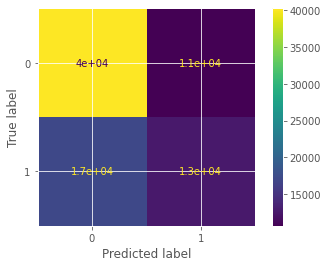

In [204]:
sig_clf = cal_sgd_clf.get_best_clf(X_train,y_train)
predict_y = sig_clf.predict_proba(X_train)

print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, sig_clf.predict_proba(X_test), labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(sig_clf,X_test, y_test)

SVM- Hinge loss

For values of alpha =  1e-05 The log loss is: 0.5788282043133279
For values of alpha =  0.0001 The log loss is: 0.5767097765887743
For values of alpha =  0.001 The log loss is: 0.5705499339557872
For values of alpha =  0.01 The log loss is: 0.5714946769984908
For values of alpha =  0.1 The log loss is: 0.5712959258997344
For values of alpha =  1 The log loss is: 0.5778966329825472
For values of alpha =  10 The log loss is: 0.6193035511555534



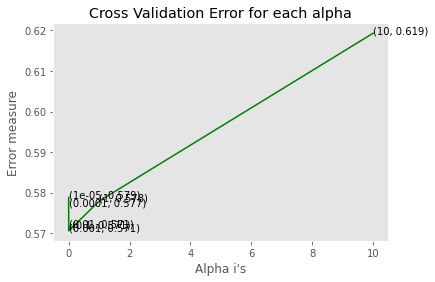

In [205]:
cal_sgd_clf = CalibSGDClassifier()
cal_sgd_clf.train(X_train,y_train,X_test,y_test,loss='hinge',penalty='l2',calib_method="sigmoid")

Best reg. const value is 0.001
Training final model:
***************
For values of best alpha =  0.01 The train log loss is: 0.5721891026057178
For values of best alpha =  0.01 The test log loss is: 0.5732806264021577
Total number of data points : 80871


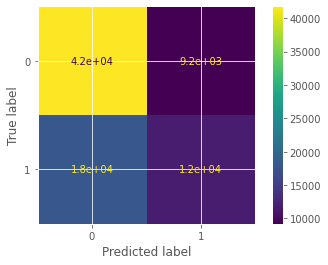

In [206]:
sig_clf = cal_sgd_clf.get_best_clf(X_train,y_train)
predict_y = sig_clf.predict_proba(X_train)

print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, sig_clf.predict_proba(X_test), labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(sig_clf,X_test, y_test)